##Fake news detection

In [106]:
##import library 
import pandas as pd
import numpy as np
import re
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from flask import jsonify
import graphviz
from nltk.corpus import stopwords
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from graphviz import Digraph
from sklearn.tree import export_graphviz
import pydot
import os

#Data Gathering

In [107]:
df = pd.read_csv("news.csv")
df.head()

,title,text,subject,date,label
0,North Korea says ICBM test used new launch veh...,SEOUL (Reuters) - North Korea said a new inter...,worldnews,29-Nov-17,TRUE
1,WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-...,The hate for our law enforcement is at an all ...,politics,18-May-15,FAKE
2,"Biden, Netanyahu discuss Iran, Islamic State, ...",WASHINGTON (Reuters) - U.S. Vice President Joe...,politicsNews,9-Mar-16,TRUE
3,Mansion where Obama to stay in Havana 'built t...,HAVANA (Reuters) - The mansion in Havana where...,politicsNews,18-Mar-16,TRUE
4,"ILLEGAL ALIENS WHO LIED TO COURT, USED FAKE SS...",You can t make this up! Why are these criminal...,left-news,12-Jun-15,FAKE


#Data Anallysis

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442 entries, 0 to 4441
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4442 non-null   object
 1   text     4442 non-null   object
 2   subject  4442 non-null   object
 3   date     4442 non-null   object
 4   label    4442 non-null   object
dtypes: object(5)
memory usage: 173.6+ KB


In [109]:
df['label'].value_counts()

label
TRUE    3050
FAKE    1392
Name: count, dtype: int64

In [110]:
df.shape

(4442, 5)

In [111]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [112]:
df = df.dropna() #Handled Missing values by droping those rows

In [113]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [114]:
df.shape

(4442, 5)

In [115]:
#reset the id (reason in notes)
df.reset_index(inplace=True)
df.head()

,index,title,text,subject,date,label
0,0,North Korea says ICBM test used new launch veh...,SEOUL (Reuters) - North Korea said a new inter...,worldnews,29-Nov-17,TRUE
1,1,WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-...,The hate for our law enforcement is at an all ...,politics,18-May-15,FAKE
2,2,"Biden, Netanyahu discuss Iran, Islamic State, ...",WASHINGTON (Reuters) - U.S. Vice President Joe...,politicsNews,9-Mar-16,TRUE
3,3,Mansion where Obama to stay in Havana 'built t...,HAVANA (Reuters) - The mansion in Havana where...,politicsNews,18-Mar-16,TRUE
4,4,"ILLEGAL ALIENS WHO LIED TO COURT, USED FAKE SS...",You can t make this up! Why are these criminal...,left-news,12-Jun-15,FAKE


#Data preprocessing

#Step 1: Tokenization

In [116]:
sample_data = 'The quick brown fox jumps over the lazy dog'
sample_data = sample_data.split()
sample_data

['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

#Step 2: Lower Case


In [117]:
sample_data = [data.lower() for data in sample_data]
sample_data

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [118]:
#downloading libraries for stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rupesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Step 3: Remove stopwords

In [119]:
stopwords = stopwords.words('english')
print(stopwords[0:10])
print(len(stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
179


#Step 4: Stemming

In [120]:
ps = PorterStemmer()
sample_data_stemming = [ps.stem(data) for data in sample_data]
print(sample_data_stemming)

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog']


In [121]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rupesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Step 5: Lamitization

In [122]:
lm = WordNetLemmatizer()
sample_data_lemma = [lm.lemmatize(data) for data in sample_data]
print(sample_data_lemma)

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazy', 'dog']


#The actual complete preprocessing of the data we have using the title

In [123]:
lm = WordNetLemmatizer()
corpus = []
for i in range (len(df)):
    review = re.sub('^a-zA-Z0-9',' ', df['title'][i]) #re means regualar expression
    review = review.lower()
    review = review.split()
    review = [lm.lemmatize(x) for x in review if x not in stopwords]
    review = " ".join(review)
    corpus.append(review)

#### Testing the preprocessing data



In [124]:
len(corpus) #length 

4442

In [125]:
#initially the title was
df['title'][0]

'North Korea says ICBM test used new launch vehicle, showed successful warhead re-entry'

In [126]:
#After preprocessing we get the same title as
corpus[0]
#here we have removed the words like(we it until) as stopwords changed into lowercase and did lamitization

'north korea say icbm test used new launch vehicle, showed successful warhead re-entry'

#Vectorizatio and classifying the test data

###IDF Function ###
parameters : corpus: set of documents; unique_words : list of sorted unique words

output : dictionary with word as key and its idf value as value


IDF formula :  $IDF(t) = 1+\log_{e}\frac{1\text{ }+\text{ Total  number of documents in collection}} {1+\text{Number of documents with term t in it}}.$




###FIT Function ###
parameters : corpus : set of documents

outputs : vocab: vocabulary dictionary; idf_dict

###Transform function###
parameters : corpus: set of documents, 
             vocab : vocabulary, 
             idf_dict

outputs : normalised sparse matrix

Using L2 Normalisation : document - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

In [127]:
tf = TfidfVectorizer()
x = tf.fit_transform(corpus).toarray()
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [128]:
y = df['label']
y.head()
y.size

4442

In [129]:
#Data splitting into the train and test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.4, random_state = 11, stratify = y )

In [130]:
len(x_train),len(y_train)

(2665, 2665)

In [131]:
len(x_test), len(y_test)

(1777, 1777)

In [132]:
#print all x_test,x_train, y_train and y_test to see whats going on for more detail
print(x_train)
print(x_test)
print(y_train)
print(y_test)
print(type(x_train))
print(type(y_train))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1125    TRUE
2913    FAKE
2392    TRUE
1869    TRUE
2566    TRUE
        ... 
3105    FAKE
1829    TRUE
180     TRUE
3448    TRUE
2921    TRUE
Name: label, Length: 2665, dtype: object
3841    TRUE
550     TRUE
1828    TRUE
3485    TRUE
515     FAKE
        ... 
486     TRUE
2394    TRUE
2358    FAKE
3238    TRUE
1135    TRUE
Name: label, Length: 1777, dtype: object
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


#Model building


## Random Forest

In [133]:
import subprocess

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=10, max_depth=10)
rf.fit(x_train, y_train)

# Create directory to save decision tree visualizations
os.makedirs('tree_visualizations', exist_ok=True)

# Export each decision tree in the Random Forest
# Extract feature names from the data itself
num_features = x_train.shape[1]  # Number of features
feature_names = [f'feature_{i}' for i in range(num_features)]  # Create generic feature names
for i, tree in enumerate(rf.estimators_):
    export_graphviz(tree, out_file=f'tree_visualizations/tree_{i}.dot',
                    feature_names=feature_names,
                    class_names=['FAKE', 'TRUE'],
                    filled=True, rounded=True)

# Convert DOT files to PNG images
for i in range(len(rf.estimators_)):
    subprocess.run(['dot', '-Tpng', f'tree_visualizations/tree_{i}.dot', '-o', f'tree_visualizations/tree_{i}.png'])

Store all the images into Images folder inside static

In [134]:
import os
import shutil

# Define the source directory containing the images
source_dir = 'tree_visualizations'

# Define the destination directory where images will be copied
destination_dir = 'static/Images'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Get a list of all files in the source directory
files = os.listdir(source_dir)

# Copy each file from the source directory to the destination directory
for file in files:
    if file.endswith('.png'):  # Check if the file is a PNG image
        source_file = os.path.join(source_dir, file)
        destination_file = os.path.join(destination_dir, file)
        shutil.copyfile(source_file, destination_file)

print("Images have been successfully copied to the 'static/Images' folder.")

Images have been successfully copied to the 'static/Images' folder.


Visualization

#Model evalation 

In [135]:
y_pred = rf.predict(x_test)
accuracy_score_ = accuracy_score(y_test,y_pred) 
accuracy_score_

0.731007315700619

In [136]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define evaluation function with visualization for both train and test data
def evaluate_with_visualization(model, x_train, y_train, x_test, y_test):
    # Predict on training data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate confusion matrix for training data
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Plot confusion matrix for training data using seaborn heatmap
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Train Data')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    # Plot confusion matrix for test data using seaborn heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens')
    plt.title('Confusion Matrix - Test Data')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.tight_layout()

    # Save the generated confusion matrix image in the Images folder inside static folder
    static_folder = 'static'
    images_folder = os.path.join(static_folder, 'Images')
    if not os.path.exists(images_folder):
        os.makedirs(images_folder)
    plt.savefig(os.path.join(images_folder, 'confusion_matrix.png'))
    plt.show()

    # Display metrics for training data
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    print("Metrics for Training Data:")
    for key, value in train_report['weighted avg'].items():
        print(f"{key.capitalize()}: {value}")

    # Display metrics for test data
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    print("\nMetrics for Test Data:")
    for key, value in test_report['weighted avg'].items():
        print(f"{key.capitalize()}: {value}")

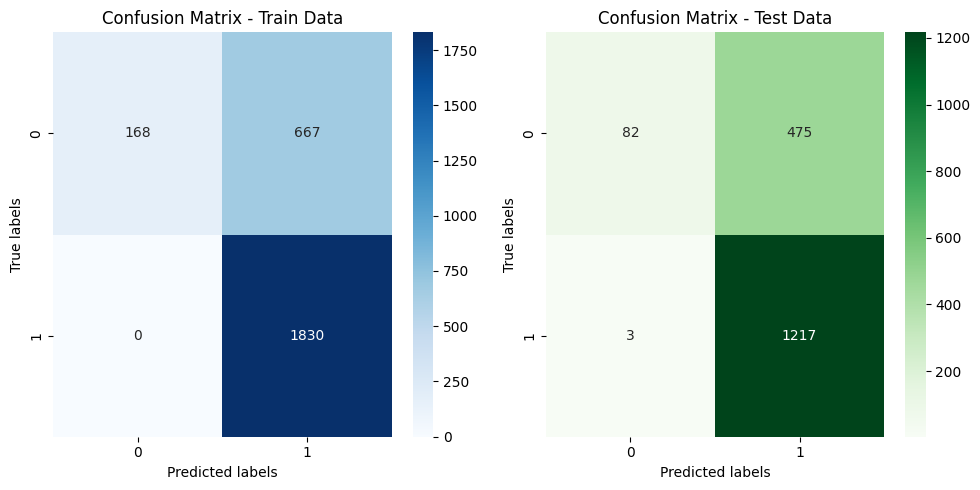

Metrics for Training Data:
Precision: 0.8165738849095462
Recall: 0.749718574108818
F1-score: 0.6857896131761841
Support: 2665.0

Metrics for Test Data:
Precision: 0.7961998236556403
Recall: 0.731007315700619
F1-score: 0.6539255010412953
Support: 1777.0


In [148]:
# Call the evaluation function with visualization
evaluate_with_visualization(rf, x_train, y_train, x_test, y_test)

#### Visualize accuracy ####

#Prediction Pieline

In [138]:
class Preprocessing:
    
    def __init__(self,data):
        self.data = data
        
    def text_preprocessing_user(self):
        lm = WordNetLemmatizer()
        pred_data = [self.data]    
        preprocess_data = []
        for data in pred_data:
            review = re.sub('^a-zA-Z0-9',' ', data)
            review = review.lower()
            review = review.split()
            review = [lm.lemmatize(x) for x in review if x not in stopwords]
            review = " ".join(review)
            preprocess_data.append(review)
        return preprocess_data    

In [139]:
df['title'][1]

'WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-SHIRT TO LEAVE COURTROOM…Or Face Contempt Charges'

In [140]:
data = 'WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-SHIRT TO LEAVE COURTROOM…Or Face Contempt Charges'
Preprocessing(data).text_preprocessing_user()

['watch judge order punk wearing “police lie” t-shirt leave courtroom…or face contempt charge']

#Prediction 

In [141]:
class Prediction:
    
    def __init__(self,pred_data, model):
        self.pred_data = pred_data
        self.model = model
        
    def prediction_model(self):
        preprocess_data = Preprocessing(self.pred_data).text_preprocessing_user()
        data = tf.transform(preprocess_data).toarray()
        prediction = self.model.predict(data)
        
        if prediction [0] == 1 :
            return "The News headline is -> True"
        
        else:
            return "The News headline is-> Fake"

In [142]:
user_data = 'Biden, Netanyahu discuss Iran, Islamic State, Syria in Jerusalem meeting'
Prediction(user_data,rf).prediction_model()

'The News headline is-> Fake'

In [143]:
df['title'][11]

'[VIDEO] RINO STRATEGIST KARL ROVE HAS SOLUTION TO GUN VIOLENCE: Repeal Second Amendment'

In [144]:
df.label[11]

'FAKE'

In [145]:
user_data='[VIDEO] RINO STRATEGIST KARL ROVE HAS SOLUTION TO GUN VIOLENCE: Repeal Second Amendment'
Prediction(user_data,rf).prediction_model()

'The News headline is-> Fake'

In [146]:
import pickle
filename='finalized_model.pkl'
pickle.dump(rf,open(filename,'wb'))

In [147]:
import pickle
filename='vectorizer.pkl'
pickle.dump(tf,open(filename,'wb'))